In [ ]:
import os
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import shap
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import skew, kurtosis
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = "/content/drive/MyDrive/FileStore/"
preprocessed_folder = drive_path + "preprocessed_eeg/"
shap_img = drive_path + "shap_img/"
model_path = drive_path + 'models/'

In [ ]:

# Create folder if it doesn't exist
os.makedirs(shap_img, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
use_feature_extraction = False  # ✅ True = extract features, False = flatten raw EEG

X_list, y_list = [], []

for file_name in sorted(os.listdir(preprocessed_folder)):
    if file_name.endswith(".npy") and not file_name.endswith("_label.npy"):
        label_file = file_name.replace(".npy", "_label.npy")
        label_path = os.path.join(preprocessed_folder, label_file)

#         # Only include files with subject ID from 1 to 81
#         if subject_id < 1 or subject_id > 81:
#             continue

        if os.path.exists(label_path):
            X = np.load(os.path.join(preprocessed_folder, file_name))
            y = np.load(label_path)
            X_list.append(X)
            y_list.append(y)
        else:
            print(f"⚠️ Missing label for: {file_name}, skipping.")


X_all = np.concatenate(X_list, axis=0)
y_all = np.concatenate(y_list, axis=0)
print(f"✅ Loaded EEG: {X_all.shape}, Labels: {y_all.shape}")

# ✨ Feature Extraction OR Flattening
if use_feature_extraction:
    print("🔍 Using extracted statistical features...")
    def extract_features(eeg_trial):
        features = []
        for ch in eeg_trial:
            features.extend([
                np.mean(ch), np.std(ch), np.min(ch), np.max(ch),
                skew(ch), kurtosis(ch)
            ])
        return features
    X_feat = np.array([extract_features(trial) for trial in X_all])
else:
    print("📉 Using flattened raw EEG signals...")
    X_feat = X_all.reshape(X_all.shape[0], -1)

print(f"✅ Feature shape for SVM: {X_feat.shape}")

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_feat, y_all, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define ML models to compare
models = {
    'SVM (RBF Kernel)': SVC(kernel='rbf', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear')
}



✅ Loaded EEG: (33191, 5, 250), Labels: (33191,)
📉 Using flattened raw EEG signals...
✅ Feature shape for SVM: (33191, 1250)


In [ ]:
for name, model in models.items():
    print(f"\n🔍 Training {name}...")
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print(f"{name} - Train Accuracy: {train_acc*100:.2f}%")
    print(f" {name} - Test Accuracy:  {test_acc*100:.2f}%")
    print(" Classification Report (Test):")
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=['Control', 'Schizo'], yticklabels=['Control', 'Schizo'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    if "SVM" in name:
        filename = os.path.join(model_path, "svm_model.joblib")
    elif "Random Forest" in name:
        filename = os.path.join(model_path, "rf_model.joblib")
    elif "Logistic Regression" in name:
        filename = os.path.join(model_path, "lr_model.joblib")
    else:
        filename = os.path.join(model_path, f"{name.replace(' ', '_').lower()}.joblib")

    joblib.dump(model, filename)
    print(f"💾 Saved model: {filename}")



🔍 Training SVM (RBF Kernel)...


In [ ]:
feature_model_path = os.path.join(model_path, "svm_feature_selection.joblib")
selector = SelectKBest(f_classif, k=50)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)

svm_fs_model = SVC(kernel='rbf', probability=True)
svm_fs_model.fit(X_train_selected, y_train)
joblib.dump(svm_fs_model, feature_model_path)
print(f"✅ Feature selection model saved to: {feature_model_path}")

# elif "Random Forest" in name:
#     filename = os.path.join(model_path, "rf_model.joblib")
#     feature_selection_path = os.path.join(model_path, "rf_feature_selection.joblib")
#     joblib.dump(model, feature_selection_path)
#     print(f"📁 Also saved SHAP model: {feature_selection_path}")

# elif "Logistic Regression" in name:
#     filename = os.path.join(model_path, "lr_model.joblib")
#     feature_selection_path = os.path.join(model_path, "lr_feature_selection.joblib")
#     joblib.dump(model, feature_selection_path)
#     print(f"📁 Also saved SHAP model: {feature_selection_path}")

# else:
#     filename = os.path.join(model_path, f"{name.replace(' ', '_').lower()}.joblib")

✅ Feature selection model saved to: /content/drive/MyDrive/FileStore/models/svm_feature_selection.joblib


In [ ]:
n_components = 20
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

svm_pca_model = SVC(kernel='rbf', probability=True)
svm_pca_model.fit(X_train_pca, y_train)

# save model
pca_model_path = os.path.join(model_path, "svm_pca_model.joblib")
joblib.dump(svm_pca_model, pca_model_path)
print("✅ PCA SVM model saved:", pca_model_path)

✅ PCA SVM model saved: /content/drive/MyDrive/FileStore/models/svm_pca_model.joblib


In [ ]:
shap_img = os.path.join(drive_path, "shap_img")
os.makedirs(shap_img, exist_ok=True)
print("✅ SHAP libray:", hasattr(shap, "summary_plot"))
import shap
print("✅ SHAP libray:", hasattr(shap, "summary_plot"))

✅ SHAP 是库: True
✅ SHAP 是库: True


In [ ]:

# First, select the K most informative features
def shap_with_feature_selection(model, X_train_scaled, X_test_scaled, y_train, k=50):
    print(f"📊 Running SHAP analysis with {k} selected features...")

    # Select top K features based on ANOVA F-value
    selector = SelectKBest(f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    # Get the indices of the selected features
    selected_indices = selector.get_support(indices=True)

    # Create feature names that map back to original features
    feature_names = [f"Feature_{i}" for i in selected_indices]

    # Train the model on selected features
    model_selected = joblib.load(feature_model_path)
    print("✅ Loaded model:", feature_model_path)

    # Create background for SHAP (use fewer samples for computational efficiency)
    background = X_train_selected[:100]

    # Create the explainer
    explainer = shap.KernelExplainer(model_selected.predict_proba, background)

    # Generate SHAP values for a few test samples
    test_samples = X_test_selected[:10]  # Use 10 samples for clarity
    shap_values = explainer.shap_values(test_samples)
    print(f"SHAP values shape: {np.array(shap_values).shape}")

    # Save SHAP values
    shap_value_path = os.path.join(model_path, "shap_values_selected.npy")
    np.save(shap_value_path, shap_values)
    print("💾 SHAP values saved:", os.path.abspath(shap_value_path))

    # For binary classification, we normally want the positive class (index 1)
    if isinstance(shap_values, list) and len(shap_values) > 1:
        class_idx = 1  # Positive class

        # Summary plot (bar)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_values[class_idx],
            test_samples,
            feature_names=feature_names,
            plot_type="bar",
            max_display=20  # Show top 20 features
        )
        plt.tight_layout()
        filename = os.path.join(shap_img, "shap_top_features_bar.png")
        plt.savefig(filename)
        print("📁 Saved:", os.path.abspath(filename))
        plt.close()

        # Summary plot (beeswarm)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_values[class_idx],
            test_samples,
            feature_names=feature_names,
            max_display=20
        )
        plt.tight_layout()
        filename = os.path.join(shap_img, "shap_top_features_beeswarm.png")
        plt.savefig(filename)
        print("📁 Saved:", os.path.abspath(filename))
        plt.close()

        # Force plot for first sample
        plt.figure(figsize=(20, 3))
        shap.force_plot(
            explainer.expected_value[class_idx],
            shap_values[class_idx][0],
            test_samples[0],
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.tight_layout()
        filename = os.path.join(shap_img, "shap_force_plot.png")
        plt.savefig(filename)
        print("📁 Saved:", os.path.abspath(filename))
        plt.close()

        # Dependence plots for top 3 features
        # Find top features by mean absolute SHAP value
        mean_abs_shap = np.abs(shap_values[class_idx]).mean(0)
        top_indices = np.argsort(mean_abs_shap)[-3:]

        for idx in top_indices:
            plt.figure(figsize=(10, 6))
            shap.dependence_plot(
                idx,
                shap_values[class_idx],
                test_samples,
                feature_names=feature_names,
                show=False
            )
            plt.tight_layout()
            filename = os.path.join(shap_img, f"shap_dependence_{feature_names[idx]}.png")
            plt.savefig(filename)
            print("📁 Saved:", os.path.abspath(filename))
            plt.close()

    return selected_indices, shap_values

def shap_with_pca(model, X_train_scaled, X_test_scaled, y_train, n_components=20):
    print(f"📊 Running SHAP analysis with PCA ({n_components} components)...")

    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Create feature names for PCA components
    feature_names = [f"PC_{i+1}" for i in range(n_components)]

    # Train the model on PCA components
    model_pca = joblib.load(pca_model_path)
    print("✅ Loaded model:", pca_model_path)


    # Create background for SHAP
    background = X_train_pca[:100]

    # Create the explainer
    explainer = shap.KernelExplainer(model_pca.predict_proba, background)

    # Generate SHAP values
    test_samples = X_test_pca[:10]
    shap_values = explainer.shap_values(test_samples)
    print(f"SHAP values shape: {np.array(shap_values).shape}")

    # save shap values
    shap_path = os.path.join(model_path, "shap_values_pca.npy")
    np.save(shap_path, shap_values)
    print("💾 SHAP values saved:", os.path.abspath(shap_path))

    # For binary classification
    if isinstance(shap_values, list) and len(shap_values) > 1:
        class_idx = 1  # Positive class

        # Summary plot (bar)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_values[class_idx],
            test_samples,
            feature_names=feature_names,
            plot_type="bar"
        )
        plt.tight_layout()
        filename = os.path.join(shap_img, "shap_pca_bar.png")
        plt.savefig(filename)
        print("📁 Saved:", os.path.abspath(filename))
        plt.close()

        # Summary plot (beeswarm)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_values[class_idx],
            test_samples,
            feature_names=feature_names
        )
        plt.tight_layout()
        filename = os.path.join(shap_img, "shap_pca_beeswarm.png")
        plt.savefig(filename)
        print("📁 Saved:", os.path.abspath(filename))
        plt.close()

        # Force plot for first sample
        plt.figure(figsize=(20, 3))
        shap.force_plot(
            explainer.expected_value[class_idx],
            shap_values[class_idx][0],
            test_samples[0],
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.tight_layout()
        filename = os.path.join(shap_img, "shap_pca_force_plot.png")
        plt.savefig(filename)
        print("📁 Saved:", os.path.abspath(filename))
        plt.close()

        # Explain how PCA components relate to original features
        plt.figure(figsize=(12, 10))
        component_idx = 0  # First component
        plt.bar(
            range(len(pca.components_[component_idx])),
            pca.components_[component_idx],
            color='steelblue'
        )
        plt.title(f"Original feature contributions to {feature_names[component_idx]}")
        plt.xlabel("Original feature index")
        plt.ylabel("Weight in component")
        plt.tight_layout()
        filename = os.path.join(shap_img, "pca_component_explanation.png")
        plt.savefig(filename)
        print("📁 Saved:", os.path.abspath(filename))
        plt.close()

    return pca, shap_values

def shap_with_feature_extraction(X_all, y_all):
    print("📊 Running SHAP analysis with extracted features...")

    # Extract features from the EEG data
    def extract_features(eeg_trial):
        # Assuming eeg_trial has shape (channels, timepoints)
        features = []
        feature_names = []

        for ch_idx, ch in enumerate(eeg_trial):
            # Calculate features for each channel
            ch_features = [
                np.mean(ch), np.std(ch), np.min(ch), np.max(ch),
                skew(ch), kurtosis(ch),
                np.median(ch), np.ptp(ch),  # peak-to-peak
                np.mean(np.abs(np.diff(ch))),  # mean absolute difference
                np.sum(np.power(ch, 2)) / len(ch)  # energy
            ]

            features.extend(ch_features)

            # Create descriptive names for each feature
            ch_feature_names = [
                f"Ch{ch_idx}_Mean", f"Ch{ch_idx}_Std", f"Ch{ch_idx}_Min", f"Ch{ch_idx}_Max",
                f"Ch{ch_idx}_Skew", f"Ch{ch_idx}_Kurtosis", f"Ch{ch_idx}_Median",
                f"Ch{ch_idx}_PTP", f"Ch{ch_idx}_MAD", f"Ch{ch_idx}_Energy"
            ]
            feature_names.extend(ch_feature_names)

        return np.array(features), feature_names

    # Extract features for all trials
    X_features = []
    for trial in X_all:
        features, names = extract_features(trial)
        X_features.append(features)

    X_features = np.array(X_features)
    feature_names = names  # Use the names from the last trial

    print(f"Extracted features shape: {X_features.shape}")

    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_all, test_size=0.2, random_state=42
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = SVC(kernel='rbf', probability=True)
    model.fit(X_train_scaled, y_train)

    # Create SHAP explainer
    background = X_train_scaled[:100]
    explainer = shap.KernelExplainer(model.predict_proba, background)

    # Generate SHAP values
    test_samples = X_test_scaled[:10]
    shap_values = explainer.shap_values(test_samples)

    print(f"SHAP values shape: {np.array(shap_values).shape}")

    # save shap values
    shap_path = os.path.join(model_path, "shap_values_extracted.npy")
    np.save(shap_path, shap_values)
    print("💾 SHAP values saved:", os.path.abspath(shap_path))

    # For binary classification
    if isinstance(shap_values, list) and len(shap_values) > 1:
        class_idx = 1  # Positive class

        # Summary plot (bar)
        plt.figure(figsize=(12, 10))
        shap.summary_plot(
            shap_values[class_idx],
            test_samples,
            feature_names=feature_names,
            plot_type="bar",
            max_display=20
        )
        plt.tight_layout()
        filename = os.path.join(shap_img, "shap_extracted_features_bar.png")
        plt.savefig(filename)
        print("📁 Saved:", os.path.abspath(filename))
        plt.close()

        # Summary plot (beeswarm)
        plt.figure(figsize=(12, 10))
        shap.summary_plot(
            shap_values[class_idx],
            test_samples,
            feature_names=feature_names,
            max_display=20
        )
        plt.tight_layout()
        filename = os.path.join(shap_img, "shap_extracted_features_beeswarm.png")
        plt.savefig(filename)
        print("📁 Saved:", os.path.abspath(filename))
        plt.close()

        # Force plot for first sample
        plt.figure(figsize=(20, 4))
        shap.force_plot(
            explainer.expected_value[class_idx],
            shap_values[class_idx][0],
            test_samples[0],
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.tight_layout()
        filename = os.path.join(shap_img, "shap_extracted_force_plot.png")
        plt.savefig(filename)
        print("📁 Saved:", os.path.abspath(filename))
        plt.close()

    return feature_names, shap_values

feature_model_path = os.path.join(model_path, "svm_feature_selection.joblib")
pca_model_path = os.path.join(model_path, "svm_pca_model.joblib")

# OPTION 1: Feature Selection
selected_indices, shap_values_selected = shap_with_feature_selection(
    model, X_train_scaled, X_test_scaled, y_train, k=50
)

# PCA
pca, shap_values_pca = shap_with_pca(
    model, X_train_scaled, X_test_scaled, y_train, n_components=20
)

# Feature Extraction
# This option retrains a model on extracted features
feature_names, shap_values_extracted = shap_with_feature_extraction(X_all, y_all)

print("✅ All SHAP analyses complete! Check the saved visualizations.")


NameError: name 'model' is not defined

In [ ]:
print(np.array(shap_values).shape)


(10, 50, 2)


<Figure size 2000x300 with 0 Axes>

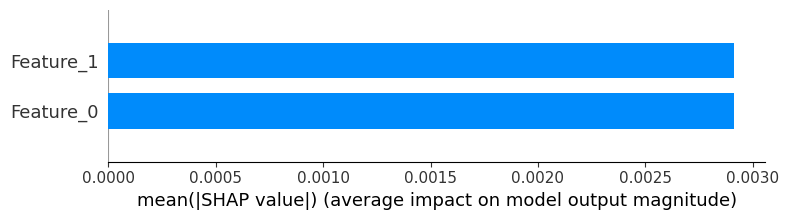

📊 Saved summary bar: /content/drive/MyDrive/FileStore/shap_img/replot_selected_bar.png


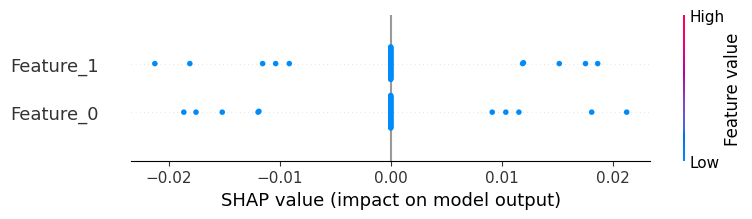

🐝 Saved beeswarm: /content/drive/MyDrive/FileStore/shap_img/replot_selected_beeswarm.png


/usr/local/lib/python3.11/dist-packages/shap/plots/_force_matplotlib.py:325: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(min_x, max_x)


⚡ Saved force plot: /content/drive/MyDrive/FileStore/shap_img/replot_selected_force.png
✅ All plots done!


In [ ]:
label = "selected"

# load shap values
shap_file = os.path.join(model_path, f"shap_values_{label}.npy")
shap_values = np.load(shap_file, allow_pickle=True)

# set class_idx
class_idx = 1

# names for features
num_features = shap_values[class_idx].shape[1]
if label == "extracted":
    feature_names = [f"Ch{ch}_{fn}" for ch in range(5) for fn in ['Mean','Std','Min','Max','Skew','Kurtosis','Median','PTP','MAD','Energy']]
else:
    feature_names = [f"Feature_{i}" for i in range(num_features)]

#  test_samples
test_samples = np.zeros_like(shap_values[class_idx])

os.makedirs(shap_img, exist_ok=True)

# Summary Bar Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values[class_idx],
    features=test_samples,
    feature_names=feature_names,
    plot_type="bar",
    max_display=50
)
plt.tight_layout()
bar_path = os.path.join(shap_img, f"replot_{label}_bar.png")
plt.savefig(bar_path)
plt.close()
print("📊 Saved summary bar:", os.path.abspath(bar_path))

# Summary Beeswarm Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values[class_idx],
    features=test_samples,
    feature_names=feature_names,
    max_display=50
)
plt.tight_layout()
bee_path = os.path.join(shap_img, f"replot_{label}_beeswarm.png")
plt.savefig(bee_path)
plt.close()
print("🐝 Saved beeswarm:", os.path.abspath(bee_path))

# Force plot (first sample)
plt.figure(figsize=(20, 3))
shap.force_plot(
    base_value=shap_values[class_idx][0].mean(),
    shap_values=shap_values[class_idx][0],
    features=test_samples[0],
    feature_names=feature_names,
    matplotlib=True,
    show=False
)
plt.tight_layout()
force_path = os.path.join(shap_img, f"replot_{label}_force.png")
plt.savefig(force_path)
plt.close()
print("⚡ Saved force plot:", os.path.abspath(force_path))

print("✅ All plots done!")

In [ ]:
def explain_with_shap(model_path, model_type, X_train_scaled, X_test_scaled, feature_names, selector=None):
    """
    Apply SHAP to a saved model.

    Args:
        model_path (str): Path to the saved .joblib model
        model_type (str): 'svm', 'rf', or 'lr'
        X_train_scaled (ndarray): Scaled training features
        X_test_scaled (ndarray): Scaled test features
        feature_names (list or array): Names of original features
        selector (SelectKBest or None): If using feature selection
    """
    print(f"\n🔍 Explaining {model_type.upper()} with SHAP...")
    svm_model_path = model_path + 'svm_model.joblib'
    # Load model
    model = joblib.load(model_path)

    # Choose SHAP explainer
    if model_type == "rf":
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_scaled)
        shap.summary_plot(shap_values[1], X_test_scaled, feature_names=feature_names)
    else:
        explainer = shap.KernelExplainer(model.predict_proba, X_train_scaled[:100])
        shap_values = explainer.shap_values(X_test_scaled[:10])
        shap.summary_plot(shap_values[1], X_test_scaled[:10], feature_names=feature_names)


# Example for SVM
explain_with_shap(
    model_path=os.path.join(model_path, "svm_model.joblib"),
    model_type="svm",
    X_train_scaled=X_train_scaled,
    X_test_scaled=X_test_scaled,
    feature_names=X.columns,
    selector=None  # or your fitted SelectKBest if used
)

# # Example for RF
# explain_with_shap(
#     model_path=os.path.join(model_path, "rf_model.joblib"),
#     model_type="rf",
#     X_train_scaled=X_train_scaled,
#     X_test_scaled=X_test_scaled,
#     feature_names=X.columns,
#     selector=None
# )

# # Example for Logistic Regression
# explain_with_shap(
#     model_path=os.path.join(model_path, "lr_model.joblib"),
#     model_type="lr",
#     X_train_scaled=X_train_scaled,
#     X_test_scaled=X_test_scaled,
#     feature_names=X.columns,
#     selector=None
# )



NameError: name 'X_train' is not defined